In [167]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def skew(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def quaternion_derivative(q, omega):
    # q: [x, y, z, w] (scipy format)
    # omega: angular velocity (rad/s)
    qw, qx, qy, qz = q[3], q[0], q[1], q[2]
    Omega = np.array([
        [0,     -omega[0], -omega[1], -omega[2]],
        [omega[0],  0,      omega[2], -omega[1]],
        [omega[1], -omega[2],  0,      omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])
    q_dot = 0.5 * Omega @ np.array([qw, qx, qy, qz])
    return np.array([q_dot[1], q_dot[2], q_dot[3], q_dot[0]])  # back to [x, y, z, w]

class IMUEKF:
    def __init__(self, init_position=None, init_velocity=None,
                 init_orientation_quat=None, accel_bias=None, gyro_bias=None):
        self.n = 16
        self.x = np.zeros(self.n)
        self.P = np.eye(self.n) * 0.1
        self.Q = np.eye(self.n) * 0.01
        self.R = np.eye(3) * 0.01

        self.g = np.array([0, 0, -9.81])
        self.last_time = None
        self.cost_history = []
        if init_position is not None:
            self.x[0:3] = init_position
        if init_velocity is not None:
            self.x[3:6] = init_velocity
        if init_orientation_quat is not None:
            q = np.array(init_orientation_quat)
            self.x[6:10] = q / np.linalg.norm(q)
        else:
            self.x[6:10] = np.array([0, 0, 0, 1])
        if accel_bias is not None:
            self.x[10:13] = accel_bias
        if gyro_bias is not None:
            self.x[13:16] = gyro_bias

    def predict(self, a_m, w_m, timestamp):
        if self.last_time is None:
            self.last_time = timestamp
            #print(self.last_time, "seconds")
            return

        dt = (timestamp - self.last_time)
        #print(dt, "seconds")
        self.last_time = timestamp
        if dt <= 0 or dt > 1.0:  # sanity check
            return

        # Extract state
        p = self.x[0:3]
        v = self.x[3:6]
        q = self.x[6:10]  # [x, y, z, w] for scipy
        ba = self.x[10:13]
        bg = self.x[13:16]

        # Bias-corrected measurements
        acc = a_m - ba
        omega = w_m - bg

        # Rotation matrix from body (IMU) to world axes
        # Convert orientation to rotation matrix
        Rwb = R.from_quat(q).as_matrix()
        # Transform accel to world frame
        a_world = Rwb @ acc
        #print(a_world, "world acceleration")

        # Integrate position and velocity
        p += v * dt + 0.5 * a_world * dt**2
        v += a_world * dt
        #print(v, "world velocity")

        # Integrate orientation using quaternion differential
        q_dot = quaternion_derivative(q, omega)
        q += q_dot * dt
        q /= np.linalg.norm(q)

        # Update state
        self.x[0:3] = p
        self.x[3:6] = v
        self.x[6:10] = q

        # Very basic linear covariance propagation (optional refinement)
        F = np.eye(self.n)
        F[0:3, 3:6] = np.eye(3) * dt
        self.P = F @ self.P @ F.T + self.Q

    def get_pose(self):
        return {
            "position": self.x[0:3],
            "velocity": self.x[3:6],
            "orientation_quat": self.x[6:10],
            "accel_bias": self.x[10:13],
            "gyro_bias": self.x[13:16]
        }

    def update(self, z, H, R=None):
        if R is None:
            R = self.R
        z_pred = H @ self.x
        y = z - z_pred
        self._measure_update(y, H, R)

    def _measure_update(self, y, H, R):
        if R is None:
            R = self.R
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.n) - K @ H) @ self.P
        
        """ Mahalanobis distance (chi-squared cost)
        It's a distance measure that accounts for uncertainty.
        Takes into account noise, correlation, covariance
        "How surprising is this new measurement, given what I already know about the system's uncertainty?" """
        cost = float(y.T @ np.linalg.inv(S) @ y)
        self.cost_history.append(cost)  # Add to a list in your class


In [110]:
imu_file = "/home/lior/Desktop/eurocMAV/mav0/imu0/data.csv"
gt_file = "/home/lior/Desktop/eurocMAV/mav0/state_groundtruth_estimate0/data.csv"
import pandas as pd
def load_imu_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["timestamp", "a_x", "a_y", "a_z", "w_x", "w_y", "w_z"]
    timestamps = df['timestamp'].values
    a_m = df[['a_x', 'a_y', 'a_z']].values
    w_m = df[['w_x', 'w_y', 'w_z']].values
    return timestamps, a_m, w_m, df

def load_gt(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["timestamp", "p_x", "p_y", "p_z","q_x", "q_y", "q_z", "q_w", "v_x", "v_y", "v_z", "b_w_x", "b_w_y", "b_w_z", "b_a_x", "b_a_y", "b_a_z"]
    timestamps = df['timestamp'].values
    p_m = df[['p_x', 'p_y', 'p_z']].values
    v_m = df[['v_x', 'v_y', 'v_z']].values
    q_m = df[['q_x', 'q_y', 'q_z', 'q_w']].values
    return timestamps, p_m, v_m, q_m, df

timestamps, a_m, w_m, df = load_imu_data(imu_file)

In [111]:
timestamps = timestamps * 1e-9  # Convert to seconds

In [ ]:
bias_accel = a_m[:500] # 2.5 seconds
bias_gyro = w_m[:500]  # 2.5 seconds
bias_accel = bias_accel.mean(axis = 0)
bias_gyro = bias_gyro.mean(axis = 0)
# 0 bias
# bias_accel = np.zeros(3)  # No bias correction
# bias_gyro = np.zeros(3)  # No bias correction


In [113]:
bias_accel, bias_gyro

(array([-0.00189054,  0.02044828,  0.07808045]),
 array([ 9.05921983,  0.11462339, -3.68390076]))

In [180]:
# init_orientation_quat = [0.060514,	-0.828459,	-0.058956,	-0.553641]
# init_pos = [0.878612, 2.14247,	0.947262]
# init_vel = [0.009474,	-0.014009,	-0.002145]
init_orientation_quat = [0, 0, 0, 1]  # identity quaternion
init_pos = [0, 0, 0]  # initial position
init_vel = [0, 0, 0]  # initial velocity
imu_ekf = IMUEKF(
    init_position=init_pos,
    init_velocity=init_vel,
    init_orientation_quat=init_orientation_quat,  # identity quaternion
    accel_bias=bias_accel,
    gyro_bias=bias_gyro
)

In [115]:
gt_data = load_gt(gt_file)

In [ ]:
def update_with_ground_truth(ekf, gt_pos, gt_quat):
    # 1. Update position
    H_pos = np.zeros((3, 16))
    H_pos[:, 0:3] = np.eye(3)
    ekf.update(gt_pos, H_pos)

    # 2. Update orientation
    q_est = ekf.x[6:10]
    q_gt = gt_quat

    R_est = R.from_quat(q_est)
    R_gt = R.from_quat(q_gt)
    rotvec_error = (R_gt * R_est.inv()).as_rotvec()  # small angle approx

    H_ori = np.zeros((3, 16))
    H_ori[:, 6:9] = np.eye(3)  # maps to minimal orientation (approx.)
 # Call internal method directly to apply residual as-is
    ekf.update(rotvec_error, H_ori)

In [185]:
trajectory_ekf = []
trajectory_gt = []
for i in range(0, len(df), 1):  # or use step of 10/20 for subsampling
    row = df.iloc[i]
    gyro = row[["w_x", "w_y", "w_z"]].values.astype(float)
    acc = row[["a_x", "a_y", "a_z"]].values.astype(float)
    timestamp = row["timestamp"]
    # get closest timestamp index from ground truth
    gt_index = np.argmin(np.abs(gt_data[0] - timestamp))
    timestamp = timestamp * 1e-9  # Convert to seconds
    timestamp_gt = gt_data[0][gt_index] * 1e-9
    gt_pos = gt_data[1][gt_index]
    gt_vel = gt_data[2][gt_index]
    gt_quat = gt_data[3][gt_index]
    imu_ekf.predict(acc, gyro, timestamp)
    if i % 100 == 0:  # Update EKF with ground truth every 100 steps (every second)
        update_with_ground_truth(imu_ekf, gt_pos, gt_quat)
    pose = imu_ekf.get_pose()
    #print(pose["position"])
    pose_pos = np.copy(pose["position"])
    trajectory_ekf.append(pose_pos)
    trajectory_gt.append(gt_pos)

trajectory_ekf = np.array(trajectory_ekf)
trajectory_gt = np.array(trajectory_gt)

## Without ground-truth EKF update calibration

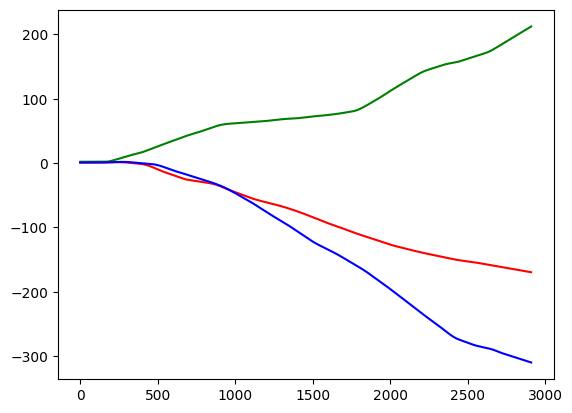

In [123]:
import matplotlib.pyplot as plt
plt.plot(trajectory_ekf[:,0], "r-", label='X Position')
plt.plot(trajectory_ekf[:,1], "g-", label='Y Position')
plt.plot(trajectory_ekf[:,2], "b-", label='Z Position')

## With EKF update calibration

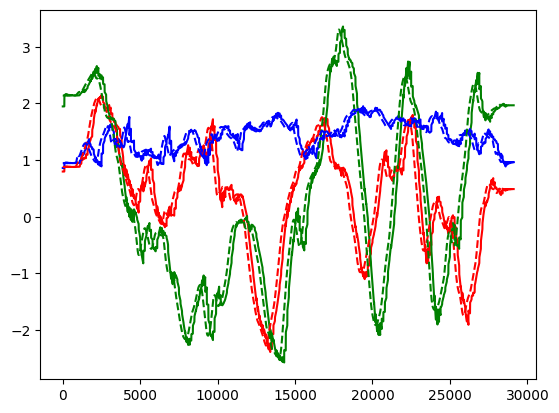

In [182]:
import matplotlib.pyplot as plt
plt.plot(trajectory_ekf[:,0], "r-", label='X Position')
plt.plot(trajectory_ekf[:,1], "g-", label='Y Position')
plt.plot(trajectory_ekf[:,2], "b-", label='Z Position')
plt.plot(gt_data[1][:,0], "r--", label='GT X Position')
plt.plot(gt_data[1][:,1], "g--", label='GT Y Position')
plt.plot(gt_data[1][:,2], "b--", label='GT Z Position')

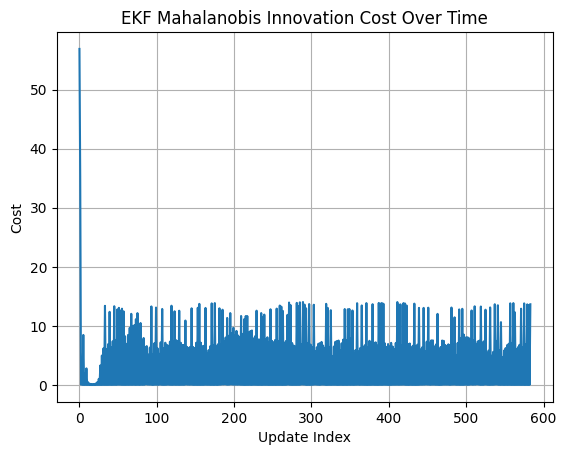

In [183]:
import matplotlib.pyplot as plt

plt.plot(imu_ekf.cost_history)
plt.title("EKF Mahalanobis Innovation Cost Over Time")
plt.xlabel("Update Index")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

In [193]:
from scipy.stats import chi2
# Average confidence of our EKF with every 100th update
average_cost_mahalonobis_squared = np.mean(imu_ekf.cost_history)
k = 3  # Degrees of freedom (3D position)
confidence = chi2.cdf(average_cost_mahalonobis_squared, df=k)
print(f"Confidence: {confidence * 100:.2f}%")

Confidence: 79.03%


In [186]:
estimates = trajectory_ekf
ground_truth = trajectory_gt

errors = estimates - ground_truth
rmse = np.sqrt(np.mean(errors**2, axis=0))
print("RMSE (x, y, z):", rmse)

RMSE (x, y, z): [0.05712965 0.06499916 0.0389622 ]


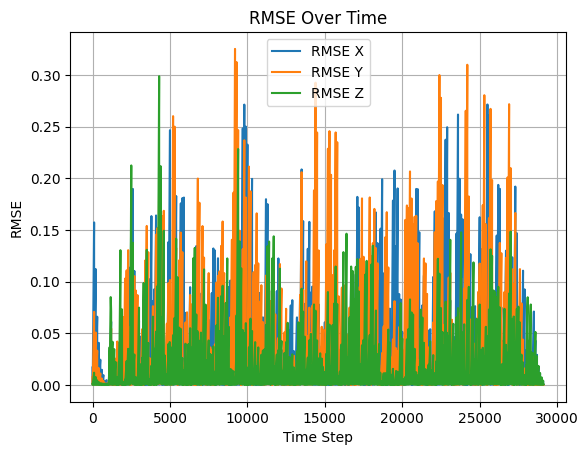

In [192]:
rmse_full = np.sqrt(errors**2)
plt.plot(rmse_full[:, 0], label='RMSE X')
plt.plot(rmse_full[:, 1], label='RMSE Y')
plt.plot(rmse_full[:, 2], label='RMSE Z')
plt.title("RMSE Over Time")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()